In [24]:
#Import Statements
import json
import glob
import geopandas as gpd
import rasterio
import fiona
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np
import tifffile
import pylibjpeg as pyjp2k
import os
import shutil
import torch

In [26]:
# code to extract the bounding box from the json metadata file for an ortho image 
# json file should have image index appended to end 

#gets the coordinates of the orthoimage to define the boundary of the new shape file 
def get_ortho_image_coordinates(base_directory, state, n=0):
    print('Getting Orthoimagery Coordinates for '+state)
    ortho_image_coordinates = []
    json_directory_path = base_directory + 'TRAN_' + state + '_Shape/Shape/images/'
    file_pattern = '*.json'
    json_file_path = glob.glob(json_directory_path + file_pattern)
    
    if len(json_file_path) == 0:
        print("No JSON files found.")
        return ortho_image_coordinates
    
    if n >= len(json_file_path):
        print("Invalid value for n.")
        return ortho_image_coordinates
    
    print(json_file_path[n])
    
    with open(json_file_path[n]) as file:
        metadata = json.load(file)
    
    bounding_box = metadata['spatial']['boundingBox']
    min_x = bounding_box['minX']
    ortho_image_coordinates.append(min_x)
    max_x = bounding_box['maxX']
    ortho_image_coordinates.append(max_x)
    min_y = bounding_box['minY']
    ortho_image_coordinates.append(min_y)
    max_y = bounding_box['maxY']
    ortho_image_coordinates.append(max_y)
    
    #coordinates stored in ortho_image_coordinates[min_x, max_x, min_y, max_y]
    return ortho_image_coordinates


def process_trail_data(state, base_directory, coordinates, image_number):
    xmin, xmax, ymin, ymax = coordinates
    
    shapefile_path = base_directory + 'TRAN_' + state + '_State_Shape/Shape'
    
    # Create the new shapefile path with image number as index
    new_shapefile_name = state + '_' + str(image_number) + '_shapefile.shp'
    new_shapefile_path = shapefile_path + '/' + new_shapefile_name
    
    gdf = gpd.read_file(shapefile_path + '/Trans_TrailSegment.shp')
    subset_gdf = gdf.cx[xmin:xmax, ymin:ymax]
    subset_gdf = subset_gdf.to_crs('EPSG:3857')
    subset_gdf.to_file(new_shapefile_path)
    
    with fiona.open(new_shapefile_path, "r") as shp:
        crs = shp.crs
    
    print(crs)
    
    gdf = gpd.read_file(new_shapefile_path)
    print(gdf.head())
    
    gdf.plot()

def calculate_trail_length(state, shapefile_index, base_directory):
    print('calculating trail length for '+state)
    shapefile_path = base_directory + 'TRAN_' + state + '_State_Shape/Shape/' + state + '_' + str(shapefile_index) + '_shapefile.shp'
    
    gdf = gpd.read_file(shapefile_path)
    gdf['trail_length'] = gdf.geometry.length
    total_trail_length = gdf['trail_length'].sum()
    total_trails = len(gdf)
    
    return(total_trail_length, total_trails)


def ortho_normalization(orthoimage_file_path, orthoimage_normalized_file_path, state, image_index):
    print('Normalizing Orthoimagey for '+state)
    image_index = str(image_index)
    file_pattern = '*'+image_index+'.jp2'
    orthoimage_files = glob.glob(orthoimage_file_path + 'images/' + file_pattern)
    orthoimagery_file_shape = glob.glob(orthoimage_file_path + '*' + image_index +'_shapefile.shp')
    orthoimagery_data = gpd.read_file(orthoimagery_file_shape[0])
    print(orthoimage_files)
    with rasterio.open(orthoimage_files[0]) as src:
        orthoimagery_pixels = src.read()
    
    normalized_data = (orthoimagery_pixels - orthoimagery_pixels.min()) / (orthoimagery_pixels.max() - orthoimagery_pixels.min())

    normalized_data_tensor = torch.from_numpy(normalized_data)

    array = normalized_data_tensor.numpy()
    normalized_array = (array * 255).astype(np.uint8)

    for index in range(normalized_data_tensor.shape[0]):
        image = Image.fromarray(normalized_array[index])
        if image.mode != 'L':
            image = image.convert('L')
        image.save(orthoimage_normalized_file_path + state + '_' + image_index + '_' + str(index) + '_' + 'full_tensor_output.jpg')

    torch.save(normalized_data_tensor, orthoimage_file_path + state + '_'+ image_index + '_tensor.pt')


def create_binary_mask(base_directory, image_index, state):
    # Read the shapefile
    print('Creating Binary Mask for '+state)
    image_index = str(image_index)
    
    output_path = os.path.join(base_directory, 'TRAN_' + state + '_State_Shape/Shape/')
    shapefile_search_suffix = state + '_' + image_index + '_shapefile.shp'
    raster_search_suffix = state +'_original_' + image_index +'.jp2' 
    shapefile_path = os.path.join(output_path, shapefile_search_suffix)
    raster_path = os.path.join(output_path + 'images/', raster_search_suffix)
    trail_data = gpd.read_file(shapefile_path)
    
    #Open raster file to use its metadata
    with rasterio.open(raster_path) as src:
        profile = src.profile
        print(profile)

    #Rasterize the shapefile
    burn_value = 1
    out_shape = (profile["height"], profile["width"]) 
    transform = profile["transform"]
    print(transform)

    #empty raster image
    burned = rasterize(
        shapes=trail_data.geometry,
        out_shape=out_shape,
        transform=transform,
        fill=0,  # Background value
        all_touched=True,
        default_value=burn_value
    )

    #Update profile 
    profile.update(count=1, dtype='uint8', nodata=None)


    # Write the raster to a new file
    normalized_burned = (burned * 255.0).astype(np.float32)
    image = Image.fromarray(normalized_burned)
    if image.mode != 'L':
            image = image.convert('L')
   
    image.save('mask_output.jpg')
    # Write the normalized burned image to a TIFF file
    output_path = output_path + state +'_raster_mask_'+ image_index + '.tif'
    tifffile.imwrite(output_path, normalized_burned, dtype='float32', bigtiff=True) 
    #CRS from the shape file = EPSG:4269
    linestring_features = trail_data[trail_data["geometry"].type == "LineString"]


def process_folders_in_directory(base_directory):
    folder_pattern = os.path.join(base_directory, 'TRAN_*_State_Shape')
    folder_paths = glob.glob(folder_pattern)
    
    for folder_path in folder_paths:
        folder_name = os.path.basename(folder_path)
        state = folder_name.split('TRAN_')[1].split('_State_Shape')[0]
        
        normalized_images_folder = os.path.join(folder_path, 'images')
        raster_images_folder = os.path.join(folder_path, 'raster_images')
        
        normalized_image_paths = glob.glob(os.path.join(normalized_images_folder, '*.jpg'))
        
        for normalized_image_path in normalized_image_paths:
            image_name = os.path.basename(normalized_image_path)
            image_number = image_name.split('_')[1]
            
            raster_image_path = os.path.join(raster_images_folder, f'{state}_original_{image_number}.jp2')
            
            #Call the necessary functions using the folder-specific paths and parameters
            coordinates = get_ortho_image_coordinates(base_directory, state, int(image_number))
            process_trail_data(state, base_directory, coordinates, int(image_number))
            calculate_trail_length(state, int(image_number), base_directory)
    
            # Move normalized image to image_dir
            image_dir = os.path.join(base_directory, 'image_dir')
            os.makedirs(image_dir, exist_ok=True)
            new_normalized_image_path = os.path.join(image_dir, f'{state}_{image_number}.jpg')
            shutil.move(normalized_image_path, new_normalized_image_path)
            
            # Copy raster mask to mask_dir
            mask_dir = os.path.join(base_directory, 'mask_dir')
            os.makedirs(mask_dir, exist_ok=True)
            new_raster_image_path = os.path.join(mask_dir, f'{state}_mask_{image_number}.jp2')
            shutil.copy(raster_image_path, new_raster_image_path)


Getting Orthoimagery Coordinates for Montana_State
/Users/andrew/Documents/Spring 2023/Intro to Deep Learning/trail_data/TRAN_Montana_State_Shape/Shape/images/58281f4ee4b01fad870ef9a5.json
[-109.4375, -109.375, 45.125, 45.1875]
EPSG:3857
                             permanenti                name  namealtern  \
0  13de412a-aa2a-415b-8b66-c5fa017a33c5     Basin Connector         NaN   
1  7e6da264-e4f5-4bf0-bd4d-cdc062ef1b9f  Silver Run Plateau         NaN   
2  43f3b9eb-731f-4cc6-b74a-8b4c7b23b86b   Silver Run Loop 3         NaN   
3  8fa39414-99d6-4c59-8906-5fa92720f7e9         Basin Lakes         NaN   
4  0f49806c-2fc2-4bdf-a793-016702f7c54a        Ingles Creek         NaN   

  trailnumbe  trailnum_1     sourcefeat  \
0       61.1         NaN     9775010355   
1         64         NaN    5046.000471   
2      102.3         NaN  1851539010602   
3         61         NaN    5044.000471   
4         35         NaN    5038.000471   

                               sourcedata           

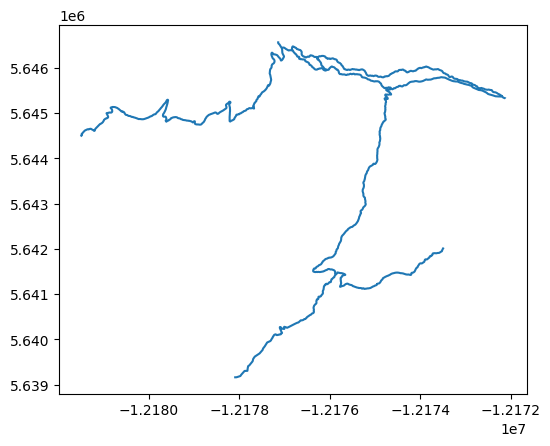

In [27]:
#Function Examples

#Example usage
base_directory = '/Users/andrew/Documents/Spring 2023/Intro to Deep Learning/trail_data/'
state = 'Montana_State'
n = 0  # Specify the nth JSON file
ortho_image_coords = get_ortho_image_coordinates(base_directory, state, n)
print(ortho_image_coords)

#Example usage
state = 'Montana'
base_directory = '/Users/andrew/Documents/Spring 2023/Intro to Deep Learning/trail_data/'
coordinates = ortho_image_coords  # Replace with the desired coordinates
image_number = 1  # Replace with the corresponding image number
process_trail_data(state, base_directory, coordinates, image_number)

#Example usage
state = 'Montana'
shapefile_index = 1 # Specify the shapefile index
base_directory = '/Users/andrew/Documents/Spring 2023/Intro to Deep Learning/trail_data/'
calculate_trail_length(state, shapefile_index, base_directory)

#Example usage
orthoimage_file_path = '/Users/andrew/Documents/Spring 2023/Intro to Deep Learning/trail_data/TRAN_Montana_State_Shape/Shape/'
orthoimage_normalized_file_path = '/Users/andrew/Documents/Spring 2023/Intro to Deep Learning/trail_data/TRAN_Montana_State_Shape/Shape/images/'
state = 'Montana'
ortho_normalization(orthoimage_file_path, orthoimage_normalized_file_path, state, '1')
create_binary_mask(base_directory, 1 , 'Montana')

#Example usage
base_directory = '/Users/andrew/Documents/Spring 2023/Intro to Deep Learning/trail_data/'
process_folders_in_directory(base_directory)


In [19]:
#check the channel number of the output images 
image_path = '/Users/andrew/Documents/Spring 2023/Intro to Deep Learning/trail_data/Imgaes for figures/Montana_1_1_full_tensor_output.jpg'  # Replace with the actual image file path
image = Image.open(image_path)

num_channels = image.getbands()

print(f"The image has {len(num_channels)}.")


The image has 1.
